In [1]:
import os
import pandas as pd
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

#Custom classes
from MyModule import *

#Use GPU if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [2]:
#File locations
data_folder='data\data_preprocessed\\'
data_file='preprocessed_2021-03-19_13-53-24_lookback_2.csv'
model_folder='model\\'
existing_model=''

#Learning parameters
learning_rate = 1e-4
batch_size = 256
epochs = 100

In [3]:
def get_norm_params(data):
    return data.mean(0), data.std(0)

def normalize_data(data, mean, std):
    return (data-mean)/std

In [4]:
#Reading data from csv
df = pd.read_csv(data_folder+ data_file)
print("Data shape"+ str(df.shape))

mean, std= get_norm_params(df)

#Splitting data to train/test data
df_train, df_test = train_test_split(df, test_size=0.2)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

#Saving test output for later plotting
Y_test=df_test[['X_pos2', 'Y_pos2']].copy()

#Normalizing data
df_train=normalize_data(df_train,mean,std)
df_test=normalize_data(df_test,mean,std)

print("Train shape"+ str(df_train.shape))

Data shape(25509, 29)
Train shape(20407, 29)


In [5]:
#Creating datasets
#Requires DatasetFast from MyModule

train_dataset=DatasetFast(df_train,batch_size,device)
test_dataset=DatasetFast(df_test,batch_size,device)

In [6]:
#Creating/Loading neural network
#Requires the corresponding class from MyModule

if existing_model=="":
    model = FeedForward_type2(train_dataset.input_size,mean,std).to(device)
    print("model created:\n")
else:
    model=torch.load(model_folder+existing_model)
    print("model loaded:\n")

print(model)

model created:

FeedForward_type2(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=27, out_features=54, bias=True)
    (1): ReLU()
    (2): Linear(in_features=54, out_features=54, bias=True)
    (3): ReLU()
    (4): Linear(in_features=54, out_features=27, bias=True)
    (5): ReLU()
    (6): Linear(in_features=27, out_features=2, bias=True)
  )
)


In [7]:
def train_loop(dataset, model, loss_fn, optimizer):
    size = dataset.batch_num
    loss_sum=0
    
    for batch in range(size):
        X, Y = dataset.batch(batch)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, Y)
        loss_sum+=loss.item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Train Error: \n Avg loss: {loss_sum/size:>8f} \n")
    return loss_sum/size
            
def test_loop(dataset, model, loss_fn):
    size = dataset.batch_num
    test_loss = 0

    with torch.no_grad():
        for i in range(size):
            X, Y = dataset.batch(i)
            pred = model(X)
            test_loss += loss_fn(pred, Y).item()

    test_loss /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

In [8]:
loss_fn = nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

#Store loss fn. value for plotting
hist_train=np.zeros((epochs,1))
hist_test=np.zeros((epochs,1))

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    if t%10==0 and t!=0:
        train_dataset.shuffle()
        print("dataset suffled")

    hist_train[t,0]=train_loop(train_dataset, model, loss_fn, optimizer)
    hist_test[t,0]=test_loop(test_dataset, model, loss_fn)
    
print("Done!")

Epoch 1
-------------------------------
Train Error: 
 Avg loss: 0.967261 

Test Error: 
 Avg loss: 0.907665 

Epoch 2
-------------------------------
Train Error: 
 Avg loss: 0.815631 

Test Error: 
 Avg loss: 0.676149 

Epoch 3
-------------------------------
Train Error: 
 Avg loss: 0.503890 

Test Error: 
 Avg loss: 0.321674 

Epoch 4
-------------------------------
Train Error: 
 Avg loss: 0.212457 

Test Error: 
 Avg loss: 0.128607 

Epoch 5
-------------------------------
Train Error: 
 Avg loss: 0.086776 

Test Error: 
 Avg loss: 0.056351 

Epoch 6
-------------------------------
Train Error: 
 Avg loss: 0.041327 

Test Error: 
 Avg loss: 0.030179 

Epoch 7
-------------------------------
Train Error: 
 Avg loss: 0.023299 

Test Error: 
 Avg loss: 0.018072 

Epoch 8
-------------------------------
Train Error: 
 Avg loss: 0.014467 

Test Error: 
 Avg loss: 0.011777 

Epoch 9
-------------------------------
Train Error: 
 Avg loss: 0.009862 

Test Error: 
 Avg loss: 0.008456 

E

Train Error: 
 Avg loss: 0.000320 

Test Error: 
 Avg loss: 0.000349 

Epoch 74
-------------------------------
Train Error: 
 Avg loss: 0.000312 

Test Error: 
 Avg loss: 0.000340 

Epoch 75
-------------------------------
Train Error: 
 Avg loss: 0.000304 

Test Error: 
 Avg loss: 0.000331 

Epoch 76
-------------------------------
Train Error: 
 Avg loss: 0.000296 

Test Error: 
 Avg loss: 0.000322 

Epoch 77
-------------------------------
Train Error: 
 Avg loss: 0.000288 

Test Error: 
 Avg loss: 0.000313 

Epoch 78
-------------------------------
Train Error: 
 Avg loss: 0.000281 

Test Error: 
 Avg loss: 0.000305 

Epoch 79
-------------------------------
Train Error: 
 Avg loss: 0.000274 

Test Error: 
 Avg loss: 0.000298 

Epoch 80
-------------------------------
Train Error: 
 Avg loss: 0.000267 

Test Error: 
 Avg loss: 0.000290 

Epoch 81
-------------------------------
dataset suffled
Train Error: 
 Avg loss: 0.000261 

Test Error: 
 Avg loss: 0.000287 

Epoch 82
--------

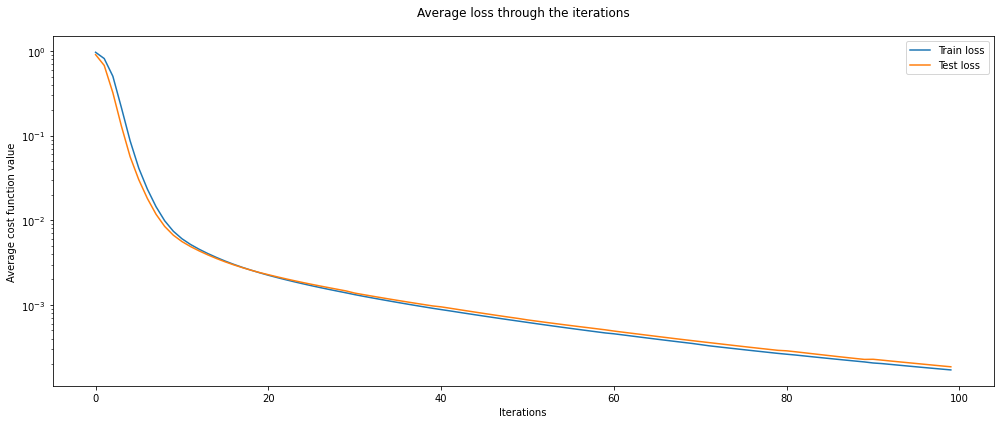

In [9]:
#Plotting loss fn. values through the iterations
e=np.arange(epochs)
plt.figure(figsize=(14,6))
plt.plot(e,hist_train,label='Train loss')
plt.plot(e,hist_test,label='Test loss')
plt.title("Average loss through the iterations",pad= 20)
plt.xlabel("Iterations")
plt.ylabel("Average cost function value")
plt.legend(loc='upper right')
plt.yscale("log")
plt.tight_layout()
plt.show()

In [10]:
#Saving trained model
model_name=model.__class__.__name__ +"__"+ datetime.now().strftime("%Y-%m-%d_%H-%M-%S")+'.pth'

torch.save(model, model_folder+model_name)
print("model saved to:\n" +model_folder+model_name)

model saved to:
model\FeedForward_type2__2021-03-22_16-50-11.pth


In [11]:
def predict(X):
    X_tensor = torch.tensor(X.to_numpy(dtype='float32'), device=device)
    with torch.no_grad():
        pred = model(X_tensor)
    pred=pred.to('cpu')
    
    pred=torch.cat((torch.reshape(pred[:,0],(X_test.shape[0],1))*model.std['X_pos2']+model.mean['X_pos2'],
                   torch.reshape(pred[:,1],(X_test.shape[0],1))*model.std['Y_pos2']+model.mean['Y_pos2']), 1)

    return pred

In [12]:
X_test=df_test.drop(columns=['X_pos2', 'Y_pos2'])
predictions=predict(X_test)
predictions

plt.figure(figsize=(8,8))
plt.scatter(Y_test['X_pos2'],predictions[:,0],label='X_pos',s=1)
plt.scatter(Y_test['Y_pos2'],predictions[:,1],label='Y_pos',s=1)
plt.title("Modell accuracy",pad= 20)
plt.xlabel("Correct positions [mm]")
plt.ylabel("Estimated positions [mm]")
plt.legend(loc='upper left')
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()